<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries for data wrangling, preprocessing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import keras.utils
from keras import utils as np_utils

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
# Importing libraries for building the neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [3]:
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full.csv


Unique values of the target variable [0 1]
Counts of the target variable : [36548  4640]
Examples:
    Total: 41188
    Yes: 4640 (11.27% of total)



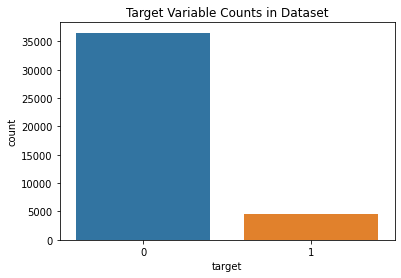

In [4]:
dataset.rename(columns = {'y':'target'}, inplace = True)
dataset['target'] = dataset.target.apply(lambda x: 1 if x == "yes" else 0)

(unique, counts) = np.unique(dataset['target'], return_counts=True)

neg = counts[0]
pos = counts[1]
total = neg + pos
print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)
print('Examples:\n    Total: {}\n    Yes: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

sns.countplot(data = dataset,x = 'target')
plt.title('Target Variable Counts in Dataset')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

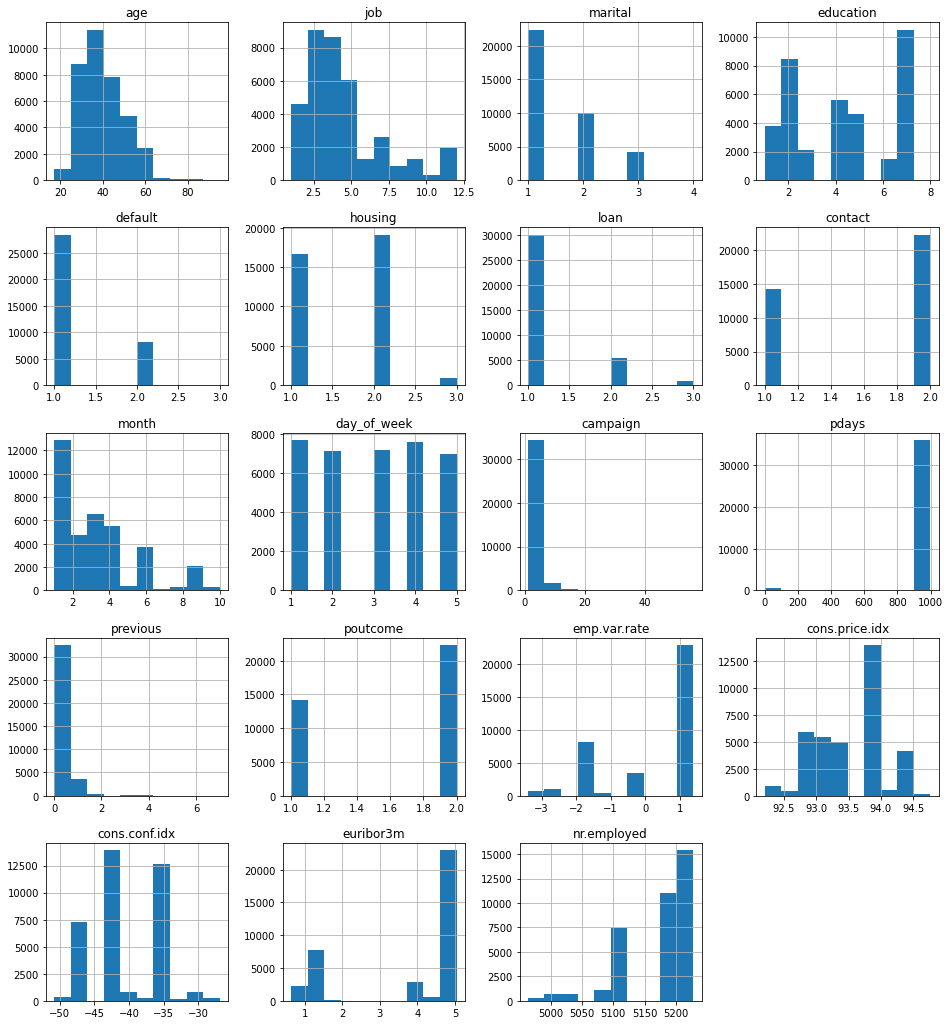

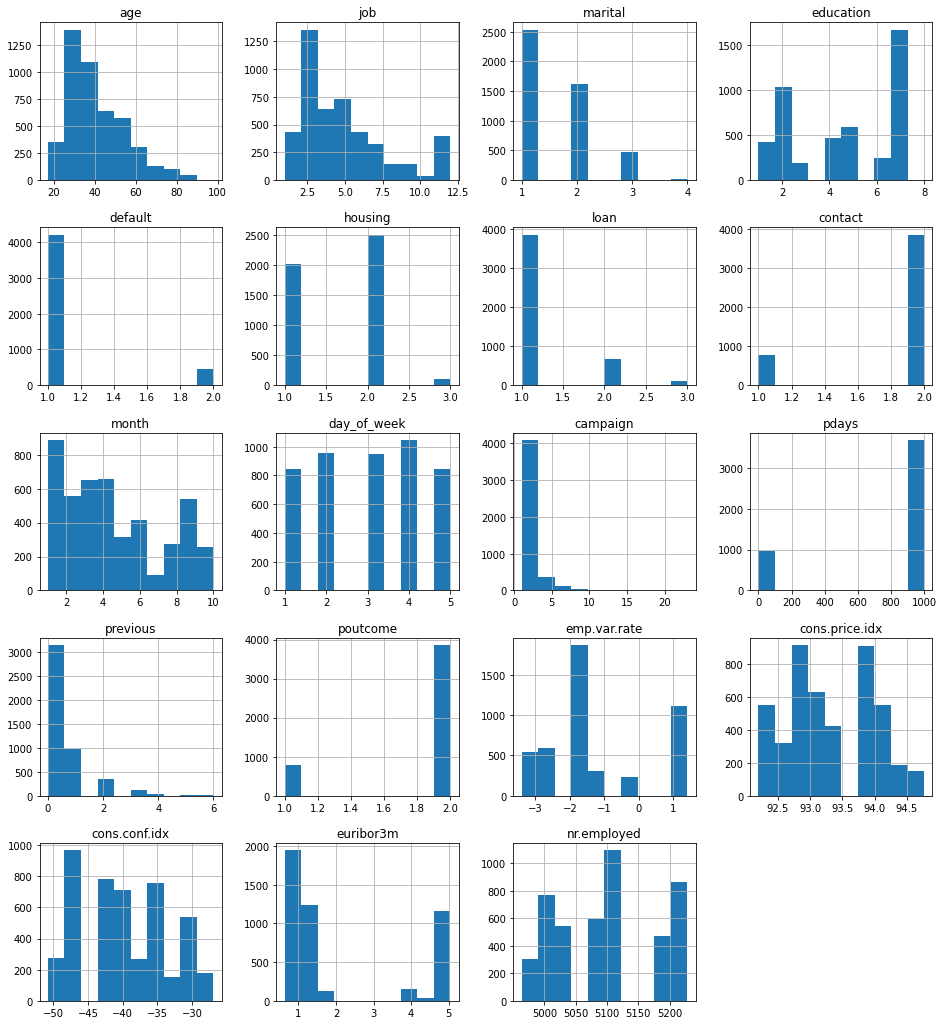

In [5]:
dataset.info()

dataset['job'] = pd.factorize(dataset['job'])[0] + 1
dataset['marital'] = pd.factorize(dataset['marital'])[0] + 1
dataset['education'] = pd.factorize(dataset['education'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['housing'] = pd.factorize(dataset['housing'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['loan'] = pd.factorize(dataset['loan'])[0] + 1
dataset['contact'] = pd.factorize(dataset['contact'])[0] + 1
dataset['month'] = pd.factorize(dataset['month'])[0] + 1
dataset['day_of_week'] = pd.factorize(dataset['day_of_week'])[0] + 1
dataset['poutcome'] = pd.factorize(dataset['contact'])[0] + 1

# Should remove - duration as only for benchmark
dataset = dataset.drop('duration', 1)

dataset.groupby('target').hist(figsize = (16,18))
dataset['previously_contacted'] = dataset.pdays.apply(lambda x: 0 if x == 999 else 1)
dataset = dataset.drop('pdays', 1)

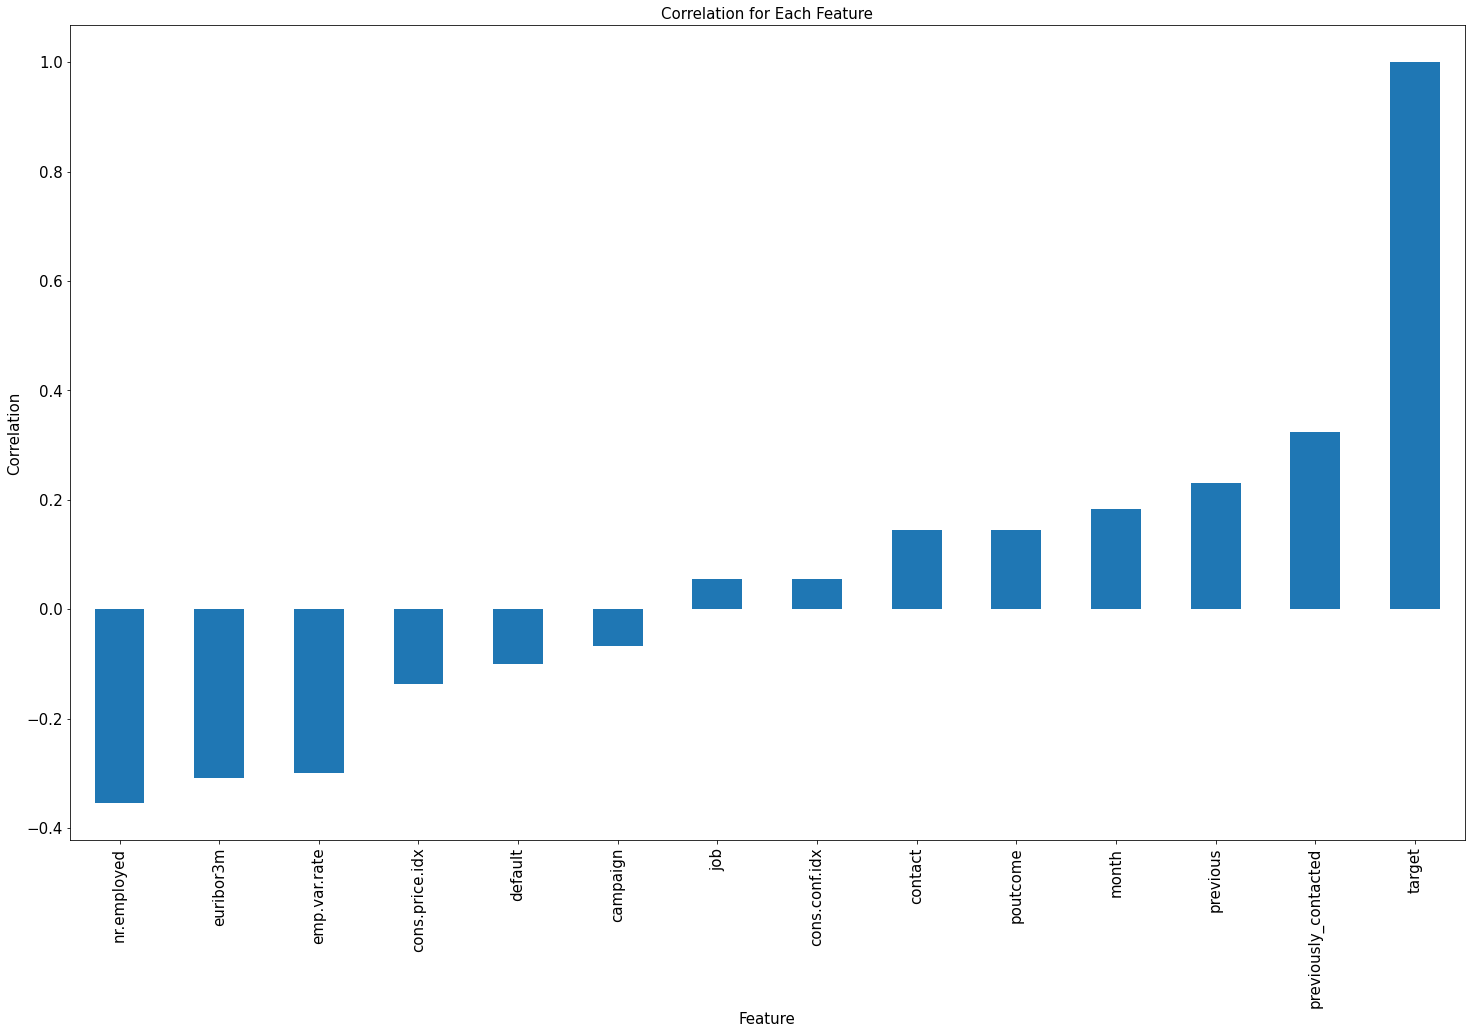

In [6]:
std_features_keep = dataset

# Create correlation matrix
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.05

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

In [30]:
X = std_features_keep.drop("target",1)   #Feature Matrix
# X = dataset.iloc[:,0:8]
y = dataset["target"]          #Target Variable

print(X.head())
print(y.head())

# Need to know no of inputs
number_inputs = len(X.columns)
test_labels = X.columns.values

   job  default  contact  ...  euribor3m  nr.employed  previously_contacted
0    1        1        1  ...      4.857       5191.0                     0
1    2        2        1  ...      4.857       5191.0                     0
2    2        1        1  ...      4.857       5191.0                     0
3    3        1        1  ...      4.857       5191.0                     0
4    2        1        1  ...      4.857       5191.0                     0

[5 rows x 13 columns]
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64
['job' 'default' 'contact' 'month' 'campaign' 'previous' 'poutcome'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'previously_contacted']


In [13]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

Mean: 0
Standard deviation: 1.0000000000000002


In [33]:
seed = 0
BATCH_SIZE = 100
np.random.seed(seed)
dataset.info()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from keras import Sequential
from keras.layers import Dense

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=number_inputs))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
#Fitting the data to the training dataset
#We iterate over 3 epochs to train the model. An epoch is an iteration over the entire data set.
classifier.compile(optimizer ='rmsprop',loss='binary_crossentropy', metrics =['accuracy'])

# Train neural network
history = classifier.fit(X_train,y_train,epochs=3,
verbose=1, batch_size=BATCH_SIZE,validation_data=(X_test, y_test)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   41188 non-null  int64  
 1   job                   41188 non-null  int64  
 2   marital               41188 non-null  int64  
 3   education             41188 non-null  int64  
 4   default               41188 non-null  int64  
 5   housing               41188 non-null  int64  
 6   loan                  41188 non-null  int64  
 7   contact               41188 non-null  int64  
 8   month                 41188 non-null  int64  
 9   day_of_week           41188 non-null  int64  
 10  campaign              41188 non-null  int64  
 11  previous              41188 non-null  int64  
 12  poutcome              41188 non-null  int64  
 13  emp.var.rate          41188 non-null  float64
 14  cons.price.idx        41188 non-null  float64
 15  cons.conf.idx      

In [34]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))

In [62]:
def plot_cm(y_true,y_predict):
  cm = tf.math.confusion_matrix(y_true,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))

% right for no:  tf.Tensor(1.0, shape=(), dtype=float64)
% right for yes:  tf.Tensor(0.0, shape=(), dtype=float64)


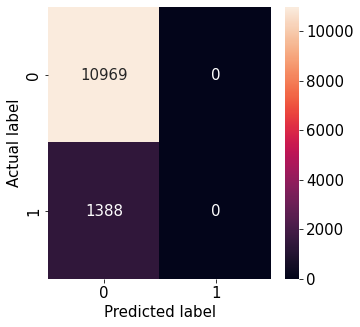

In [63]:
y_predict=classifier.predict(X_test)
y_true=y_test
plot_cm(y_true,y_predict)